## Demonstration of scNiche on the human upper tract urothelial carcinoma (UTUC) IMC data

In this tutorial, we will show you the application of the batch training strategy of scNiche on large-scale datasets containing multiple slices.
The [human UTUC IMC dataset (*Nat Commun., 2024*)](https://doi.org/10.1038/s41467-024-46320-w) contains a total of about 110,000 cells from 16 slices.

In [1]:
import scniche as sn
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.0.0


In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/46669108)
# adata = sn.datasets.human_utuc_imc()
adata = sc.read('UTUC/data/utuc.h5ad')
len(set(adata.obs['roi']))

16

[<AxesSubplot: title={'center': 'cell_type_broad'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'topological_domain'}, xlabel='spatial1', ylabel='spatial2'>]

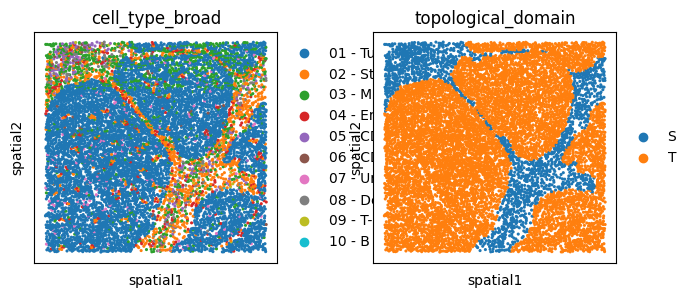

In [3]:
# 20210310_PM57_B8-01 as an example
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata[adata.obs['roi'] == '20210310_PM57_B8-01'], basis="spatial", color=['cell_type_broad', 'topological_domain', ],s=20, show=False, )

In [4]:
celltype_key = 'cell_type_broad'
sample_key = 'roi'
target_num = 2
k_cutoff = 30
batch_num = 20
epochs = 100

# prepare
adata = sn.pp.process_multi_slices(
    adata=adata,
    celltype_key=celltype_key,
    sample_key=sample_key,
    mode='KNN',
    k_cutoff=k_cutoff,
    is_pca=False,
    verbose=False
)
adata = sn.pp.prepare_data_batch(adata=adata, verbose=False, batch_num=batch_num)
# training
model = sn.tr.Runner_batch(adata=adata, device='cuda:0', verbose=False)
adata = model.fit(lr=0.01, epochs=epochs)
# clustering
adata = sn.tr.clustering(adata=adata, target_k=target_num)

-------Process 16 slices...


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


[<AxesSubplot: title={'center': 'cell_type_broad'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'topological_domain'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'scNiche'}, xlabel='spatial1', ylabel='spatial2'>]

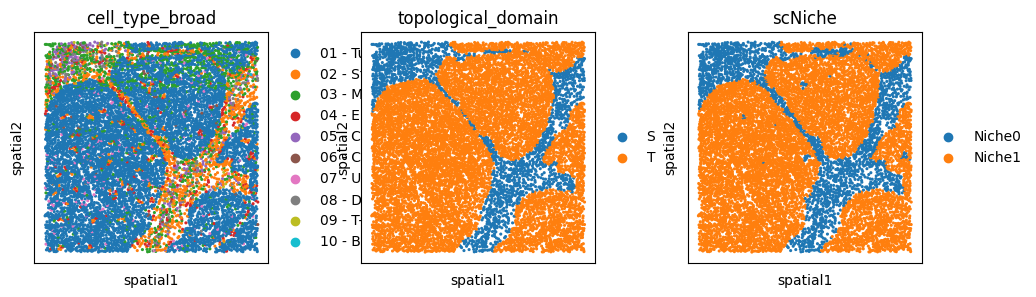

In [5]:
# 20210310_PM57_B8-01 as an example
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata[adata.obs['roi'] == '20210310_PM57_B8-01'], basis="spatial", color=['cell_type_broad', 'topological_domain', 'scNiche'],s=20, show=False, )

In [8]:
import pandas as pd
import numpy as np

dataset_list = []
ari_list = []
sample_list = sorted(list(set(adata.obs['roi'])))
res = adata.obs.copy()

for i in sample_list:
    res_tmp = res.loc[res['roi'] == i]
    a = res_tmp['topological_domain'].values
    b = res_tmp['scNiche'].values
    # ari
    ari_tmp = adjusted_rand_score(a, b)
    
    dataset_list.append(i)
    ari_list.append(ari_tmp)

eva_df = pd.DataFrame({'Dataset': dataset_list, 'ARI': ari_list, })

print(f"Mean ARI: {np.mean(eva_df.ARI)}; Median ARI: {np.median(eva_df.ARI)}")

Mean ARI: 0.631977278252031; Median ARI: 0.6814779974494014
